In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence, Tuple
from antea.elec import tof_functions as wvf 
from scipy import signal
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from proposals import SQRT_integrator as integrator
from proposals import LOG_integrator
from waveforms import wave_gen

%matplotlib nbagg
%reload_ext autoreload
%autoreload 2

In [36]:
# Time unit (tu) -> 100 ps

time_unit = 100E-12 
VTH = 0.55
MAX_PE = 1000
LSB_PE_L = 4
PE_inc = 0.25
PULSE_LENGTH = 5000

#TIME_rnd = np.add.accumulate(np.random.poisson(9,100))
#PE_rnd   = np.random.choice([1,2],100,replace=True,p=[0.95,0.05])
TIME_rnd     = np.array([ 500, 570,1000,1040,1060,1100,1110,1160,1200,1230,1300,
                          1400,1440,1460,1500,1510,1560,1600,1630,1700,1710,1750])
PE_rnd       = np.array([   1,   4,  30,  40,  25,  15,  20,  25,  30,  10,   4,   
                           25,  35,  20,  10,  40,  30,  15,  10,   5,   4,   1])

TIME         = np.arange(0,(MAX_PE/PE_inc)*PULSE_LENGTH,PULSE_LENGTH)
PE           = np.arange(0,MAX_PE,PE_inc)

In [3]:
def find_nearest_bigger(A,val):
    return np.where(A-val > 0, A-val, np.inf).argmin()

def find_nearest(A,val):
    return np.abs(A-val).argmin()

def PE_2_LSB_LUT(DAC_array, PE_charge_array, PE_inc, MAX_PE):
    # PE_inc = PE delta from position to position in array
    # Function returns PE array
    pe_lsb_lut=[]
    for code_v in DAC_array:
        data = find_nearest_bigger(PE_charge_array,code_v)
        pe_lsb_lut.append(data*PE_inc)
    PE_LSB_LUT = np.array(pe_lsb_lut)
    LSB_per_PE = np.array([np.sum(np.floor(PE_LSB_LUT) == x) for x in np.arange(1, MAX_PE)])
    return PE_LSB_LUT,LSB_per_PE


In [4]:
time,signal_out = wave_gen(np.vstack([TIME,PE]), time_unit, Bandwidth=25E6)

CHECK: Electrons in spe_response = 1.000000


<IPython.core.display.Javascript object>


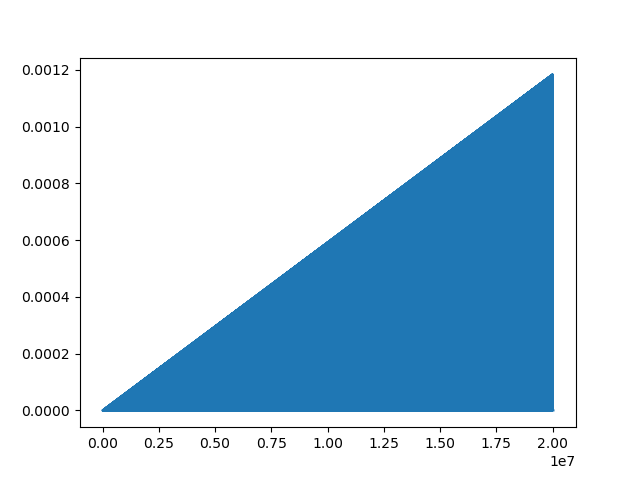

In [5]:
plt.figure()
plt.plot(signal_out)

### MAX NUMBER OF PE = 500
### LINEAR CONVERSION  --   PE = 4 LSB !!!! (Not a good idea)
### Noise threshold (est.) = 80uV  /  80nA

# LINEAR CONVERSION

In [37]:


I1=integrator(KPP_2n=150E-6, W_L=10, VTH=VTH, time_unit=100E-12, cap=10E-12)
I_o = np.ones(PULSE_LENGTH)*10E-6
I_a = np.ones(PULSE_LENGTH)*10E-6
Ipeak_array=[]
vGSpeak_array=[]
for i in range(1,len(PE)):
    Iout,vGS_C = I1.ideal(I_o, I_a, signal_out[i*PULSE_LENGTH:(i+1)*PULSE_LENGTH])
    Ipeak_array.append(np.max(Iout))
    vGSpeak_array.append(np.max(vGS_C))    
Ipeak_array_L = np.array(Ipeak_array)
vGSpeak_array_L = np.array(vGSpeak_array)

MAX_current = np.max(Ipeak_array_L)
PE_current = np.min(Ipeak_array_L)/PE_inc

N_bits_L = 11 #np.ceil(np.log2(LSB_PE_L*MAX_PE))
#N_bits_L = np.log2(LSB_PE_L*MAX_PE)
I_LSB = (PE_current)/LSB_PE_L

I_range_array  = np.array([x for x in np.arange(0,2**N_bits_L)])*I_LSB
#PE_range_array_L = np.array([find_nearest_bigger(Ipeak_array_L,x) for x in I_range_array])
#PE_range_array_L = np.arange(0,2**N_bits) / LSB_PE_L
PE_range_array_L,dump = PE_2_LSB_LUT(I_range_array, Ipeak_array, PE_inc, MAX_PE)


print("Maximum Integrator Current Output = %e" % MAX_current)
print("Minimum Integrator Current Output = %e" % PE_current)
print("LSB value in uA = %e" % ((PE_current/1E-6)/LSB_PE_L))
print("Required BITS for PE Dynamic Range = %f" % N_bits_L)

Maximum Integrator Current Output = 1.961673e-03
Minimum Integrator Current Output = 1.962059e-06
LSB value in uA = 4.905149e-01
Required BITS for PE Dynamic Range = 11.000000


# SQUARE ROOT COMPRESSION CONVERSION

In [38]:
Gain_sqrt = 1.1

# Square Root Compression
I2=integrator(KPP_2n=150E-6, W_L=10, VTH=VTH, time_unit=100E-12, cap= 7E-12)
I_o = np.ones(PULSE_LENGTH)*10E-6
I_a = np.ones(PULSE_LENGTH)*5E-6
Ipeak_array=[]
vGSpeak_array=[]
for i in range(1,len(PE)):
    Iout,vGS_C = I2.ideal(I_o, I_a, signal_out[i*PULSE_LENGTH:(i+1)*PULSE_LENGTH],Gain_sqrt)
    Ipeak_array.append(np.max(Iout))
    vGSpeak_array.append(np.max(vGS_C))
Ipeak_array = np.array(Ipeak_array)
vGSpeak_array = np.array(vGSpeak_array)

# Voltage Full Scale of 1V sampled at N_bits. Let's find equivalence from V to PE
N_bits = 11
V_LSB = 1/(2**N_bits)
V_range_array  = np.array([x for x in np.arange(0,2**N_bits)])*V_LSB
vGS_D = vGSpeak_array-VTH

PE_range_array,PE_LSB = PE_2_LSB_LUT(V_range_array, vGS_D, PE_inc, MAX_PE)

print("LSB value in mV = %e" % (V_LSB/1E-3))
print("The highest step in PE = %e" % np.max(np.diff(PE_range_array)),"and is around code %d" % np.argmax(np.diff(PE_range_array)))
#The highest step must be 1 in order not to loose PE


LSB value in mV = 4.882812e-01
The highest step in PE = 1.000000e+00 and is around code 1647


# LOGARITHMIC COMPRESSION CONVERSION

In [45]:
Gain_log = 1
# (Ibias2/self.cap2.C)*(self.R*self.cap1.C)*(np.log(self.cap1.vC(Iin)/self.R+Ibias3)-np.log(Ibias3))
# Loharithmic Compression
I3=LOG_integrator(KPP_2n=150E-6, W_L=10, VTH=VTH, time_unit=100E-12, 
                      cap1=1E-12, cap2=0.6E-12, R=11E3)
Ibias1 = np.ones(PULSE_LENGTH)*10E-6
Ibias2 = np.ones(PULSE_LENGTH)*10E-6
Ibias3 = np.ones(PULSE_LENGTH)*80E-6
Ipeak_array=[]
vOUT_peak_array=[]
for i in range(1,len(PE)):
    vOUT = I3.ideal(signal_out[i*PULSE_LENGTH:(i+1)*PULSE_LENGTH]*Gain_log,Ibias1,Ibias2,Ibias3)
    vOUT_peak_array.append(np.max(vOUT))
vOUT_peak_array = np.array(vOUT_peak_array)

# Voltage Full Scale of 1V sampled at N_bits. Let's find equivalence from V to PE
N_bits_LOG = 11
V_LSB_LOG = 1/(2**N_bits_LOG)
V_range_array_LOG  = np.array([x for x in np.arange(0,2**N_bits_LOG)])*V_LSB_LOG
PE_range_array_LOG,PE_LSB_LOG = PE_2_LSB_LUT(V_range_array_LOG, vOUT_peak_array, PE_inc, MAX_PE)

print("LSB value in mV = %e" % (V_LSB_LOG/1E-3))
print("The highest step in PE = %e" % np.max(np.diff(PE_range_array_LOG)),"and is around code %d" % np.argmax(np.diff(PE_range_array_LOG)))
#The highest step must be 1 in order not to loose PE

LSB value in mV = 4.882812e-01
The highest step in PE = 2.750000e+00 and is around code 1676


<IPython.core.display.Javascript object>


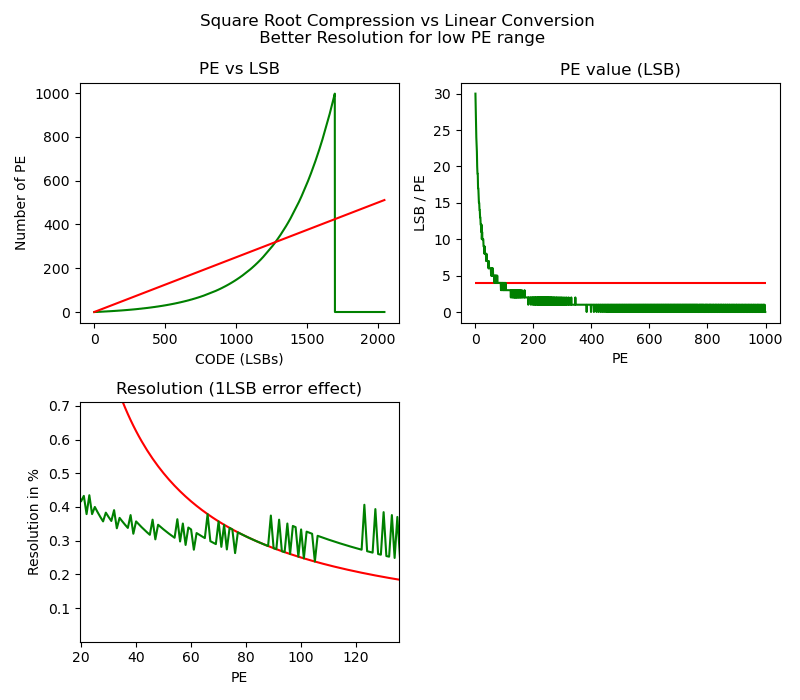

<ipython-input-46-7c9eb0959aae>:25: RuntimeWarning: divide by zero encountered in true_divide
  RES     = np.divide(np.divide(np.ones(len(PE_LSB)),PE_LSB),np.arange(1,MAX_PE))*100
<ipython-input-46-7c9eb0959aae>:26: RuntimeWarning: divide by zero encountered in true_divide
  RES_LOG = np.divide(np.divide(np.ones(len(PE_LSB_LOG)),PE_LSB_LOG),np.arange(1,MAX_PE))*100


In [46]:
fig2 = plt.figure(figsize=(8,7))
fig2.suptitle("Square Root Compression vs Linear Conversion \n Better Resolution for low PE range")
SP1 = fig2.add_subplot(221)
SP1.set_title("PE vs LSB")
SP1.set_xlabel("CODE (LSBs)")
SP1.set_ylabel("Number of PE")
#SP1.plot(PE_range_array,'b')
SP1.plot(PE_range_array_LOG,'g')
SP1.plot(PE_range_array_L,'r')

SP2 = fig2.add_subplot(222)
SP2.set_title("PE value (LSB)")
SP2.set_xlabel("PE")
SP2.set_ylabel("LSB / PE")
#SP2.plot(np.arange(1,MAX_PE),PE_LSB,'b')
SP2.plot(np.arange(1,MAX_PE),PE_LSB_LOG,'g')
SP2.hlines(LSB_PE_L,1,MAX_PE,colors='r')

SP3 = fig2.add_subplot(223)
SP3.set_title("Resolution (1LSB error effect)")
SP3.set_xlabel("PE")
SP3.set_ylabel("Resolution in %")

RES_L   = np.divide(1/LSB_PE_L,np.arange(1,MAX_PE))*100
RES     = np.divide(np.divide(np.ones(len(PE_LSB)),PE_LSB),np.arange(1,MAX_PE))*100
RES_LOG = np.divide(np.divide(np.ones(len(PE_LSB_LOG)),PE_LSB_LOG),np.arange(1,MAX_PE))*100


#SP3.plot(np.arange(1,MAX_PE),RES,'b')
SP3.plot(np.arange(1,MAX_PE),RES_L,'r')
SP3.plot(np.arange(1,MAX_PE),RES_LOG,'g')

#SP4 = fig2.add_subplot(224)
#SP4.set_title("PE range array")
#SP4.set_xlabel("CONDE (LSBs)")
#SP4.set_ylabel("PE")
#SP4.plot(PE_range_array)

plt.show()
fig2.tight_layout()